In [1]:
import os
import cv2
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras.applications.inception_v3 import preprocess_input

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# this is the augmentation configuration we will use for training

train_datagen = ImageDataGenerator(rescale=1.0/255)
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'D:/Project/cats vs dogs/data/train2',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=8,
        shuffle=False,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'D:/Project/cats vs dogs/data/validation',
        target_size=(150, 150),
        batch_size=8,
        shuffle=False,
        class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
#for i in train_generator:
#    idx = (train_generator.batch_index - 1) * train_generator.batch_size
#    print(train_generator.filenames[idx : idx + train_generator.batch_size])

In [ ]:
x, y = validation_generator.__next__()

plt.figure(figsize=(15, 15))

for i, (img, label) in enumerate(zip(x, y)):
    if label == 1:
        plt.title(label)
    else:
        plt.title(label)
    if i==20:
        break
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
#    plt.axis('off')

In [3]:
input= Input(shape=(150, 150, 3))
x=Lambda(xception.preprocess_input)(input)

base_model = Xception(weights='imagenet', input_tensor=x,include_top=False)
#model = Model(base_model.input,GlobalAveragePooling2D()(base_model.output))

x = Flatten()(base_model.output)
#x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.85)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input,outputs=output)

for layer in model.layers[:132]:
    layer.trainable = False
#model.summary()

In [5]:
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit_generator(
        train_generator,
        epochs=40,
#        steps_per_epoch=50,
#        validation_steps=20,
        validation_data=validation_generator,
        callbacks=[TensorBoard(log_dir='./log')])
#model.save_weights('first_try.h5')  # always save your weights after training or during training
model.save('model.h5')

Epoch 1/40
3125/3125 [==============================] - 1148s 367ms/step - loss: 0.6500 - acc: 0.6217 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 2/40
3125/3125 [==============================] - 1112s 356ms/step - loss: 0.5318 - acc: 0.7336 - val_loss: 0.6930 - val_acc: 0.5062
Epoch 3/40
3125/3125 [==============================] - 1111s 355ms/step - loss: 0.4272 - acc: 0.8020 - val_loss: 0.6929 - val_acc: 0.5018
Epoch 4/40
3125/3125 [==============================] - 1111s 356ms/step - loss: 0.3581 - acc: 0.8410 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 5/40
3125/3125 [==============================] - 1111s 355ms/step - loss: 0.3101 - acc: 0.8681 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/40
3125/3125 [==============================] - 1111s 356ms/step - loss: 0.2811 - acc: 0.8817 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 7/40
3125/3125 [==============================] - 1112s 356ms/step - loss: 0.2552 - acc: 0.8958 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 8/40
3125/3125 [=====

In [ ]:
test_length = len(os.listdir('D:/Project/cats vs dogs/data/test'))
test = np.zeros((test_length,150,150, 3), dtype=np.uint8)

##生成test image
for file_name in os.listdir('D:/Project/cats vs dogs/data/test'):
    index = int(file_name.split('.')[0])-1  #文件名和默认的index相差1
    test[index] = cv2.resize(cv2.imread('D:/Project/cats vs dogs/data/test'+'/'+file_name),(150,150))
    b,g,r = cv2.split(test[index])       # get b,g,r
    test[index] = cv2.merge([r,g,b])  # switch it to rgb
np.save('D:/Project/cats vs dogs/test.npy',test)

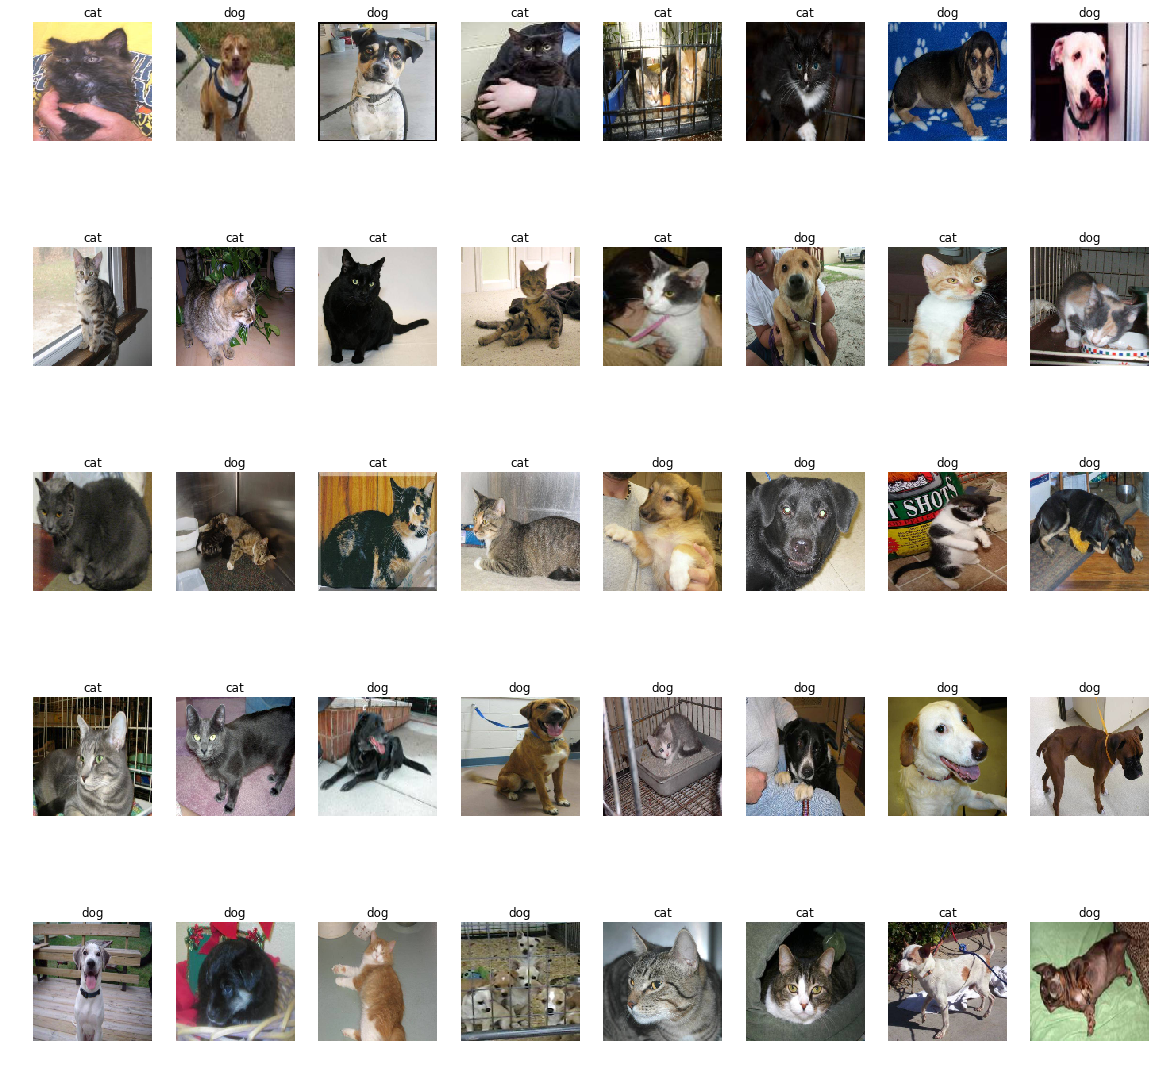

In [6]:
#from keras import imagenet_utils
#from keras.preprocessing import image as image_utils
#from imagenet_utils import preprocess_input

test = np.load('D:/Project/cats vs dogs/test.npy')
from keras.models import load_model
#model_2 = load_model('model.h5')
#预测的可视化
plt.figure(figsize=(20, 20))
for i in range(40):
    index=random.randint(0,len(test))
    pred = model.predict(test[index:index+1])
    if pred >0.5:
        title='dog'
    else:
        title='cat'
    plt.subplot(5,8,i+1)
    plt.title(title)
    plt.imshow(test[index])
    plt.axis('off')


In [8]:
##将预测写入csv
with open('file.csv','w') as f:
    f.write('id,label\n')
with open('file.csv','a') as f:
    for i in range(len(test)):
        pred = model.predict(test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))
